**Выпускной проект. Телеком**
_____
**Описание исследования.**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов.

Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.
Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.
_____
**Цель исследования.**

Обучить модель на персональных данных клиентов, для предсказания расторжения догора


**Задачи исследования.**

- Загрузить данные и провести исследовательский анализ

- Подготовить данные к обучению модели

- Обучить и протестировать модель, получив метрику не `ROC-AUC` не менее 0,85

_____
**Исходные данные.**

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом.

Она состоит из нескольких таблиц:
- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.
_____
**Содержание проекта.**

***Загрузка данных:***
* [Загрузка библиотек.](#1-bullet)
* [Изученеие файла с данными, получение общей информации.](#2-bullet)

***Исследовательский анализ***
* [Предобработка](#3-bullet)
* [Гистограмма и ящик для количественных данных](#4-bullet)
* [Оценка категориальных значений](#5-bullet)
* [Объединение датафреймов](#6-bullet)
* [Построение корреляционной матрицы](#7-bullet)

***Подготовка данных к обучению моделей***
* [Построение пайплайна предобработки](#8-bullet)

***Обучение моделей***
* [Определение параметров моделей](#9-bullet)
* [Обучение моделей](#10-bullet)
* [Модель нейронной сети](#11-bullet)

***Демонстрация лучшей модели***
* [Матрица ошибок](#12-bullet)

***Итоговый вывод***

##Загрузка данных:

### Загрузка библиотек
<a id='1-bullet'></a>

In [ ]:
#Установка нужных бибилотек
import sys
!"{sys.executable}" -m pip install phik -q
#!"{sys.executable}" -m pip install shap -q
!"{sys.executable}" -m pip install catboost -q
!"{sys.executable}" -m pip install category-encoders -q
!"{sys.executable}" -m pip install sqlalchemy -q
!"{sys.executable}" -m pip install category-encoders -q

#Импорт стандартных библиотек Python
import os
import re
import math
import time
import warnings
from itertools import product
from warnings import simplefilter

#Обработка данных
import numpy as np
import pandas as pd
from scipy import stats

#Машинное обучение и обработка данных
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, r2_score, roc_auc_score,
                             roc_curve)

from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_random_state

from category_encoders import TargetEncoder

#Специализированные библиотеки для машинного обучения
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam, Adam #, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

#Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

#Объяснимость моделей
from phik import phik_matrix
from phik.report import plot_correlation_matrix

#БД
from sqlalchemy import create_engine, text

simplefilter(action='ignore', category=FutureWarning)
RANDOM_STATE=170225

### Изученеие файла с данными, получение общей информации
<a id='2-bullet'></a>

In [ ]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2025-02-22 14:16:46--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db’

ds-plus-final.db    100%[===================>]   3.42M  --.-KB/s    in 0.07s   

2025-02-22 14:16:46 (49.1 MB/s) - ‘ds-plus-final.db’ saved [3588096/3588096]



In [ ]:
#Загрузка данных
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

contract = '''
SELECT *
FROM contract;
'''
personal = '''
SELECT *
FROM personal;
'''
internet = '''
SELECT *
FROM internet;
'''
phone = '''
SELECT *
FROM phone;
'''
df_contract = pd.read_sql_query(contract, engine)
df_personal = pd.read_sql_query(personal, engine)
df_internet = pd.read_sql_query(internet, engine)
df_phone = pd.read_sql_query(phone, engine)

In [ ]:
#Оценка имеющихся данных
for df_name in ['df_contract', 'df_personal', 'df_internet', 'df_phone']:
    df = globals()[df_name]
    print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')
    print(f"\nИнфо по {df_name}:")
    print(df.info())
    print("\nДанные:")
    display(df.head(4))
    display(df.describe(include='all'))

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Инфо по df_contract:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB
None

Данные:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,1585,6658
top,6599-GZWCM,2014-02-01,No,Month-to-month,Yes,Electronic check,20.05,
freq,1,366,5942,3875,4171,2365,61,11


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Инфо по df_personal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None

Данные:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,6599-GZWCM,Male,0,No,No
freq,1,3555,5901,3641,4933


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Инфо по df_internet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Данные:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6599-GZWCM,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Инфо по df_phone:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Данные:


,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes


,CustomerId,MultipleLines
count,6361,6361
unique,6361,2
top,6599-GZWCM,No
freq,1,3390


**Вывод**

- В данных нет пропусков, но есть пустые значения
- Столбцы почти соответствует своим типам
- Названия столбцов не в "змеином" стиле

##Исследовательский анализ

### Предобработка
<a id='3-bullet'></a>

In [ ]:
#Функция для перименования
def snake_case(col_name):
    col_name = re.sub(r'[^\w\s]', '_', col_name)
    col_name = re.sub(r'(\w)([A-Z])', r'\1_\2', col_name).lower()
    col_name = col_name.replace(' ', '_')
    col_name = re.sub(r'_+', '_', col_name)
    col_name = col_name.strip('_')

    return col_name

for df_name in ['df_contract', 'df_personal', 'df_internet', 'df_phone']:
    df = globals()[df_name]
    df.columns = [snake_case(col) for col in df.columns]

In [ ]:
#Функция по поиску дублей
def analyze_df(df, categorical_traits):

    print('Количество пропусков в солбцах:')
    display(df.isna().mean() * 100)

    print('Количество дубликатов в столбцах:')
    display(df.apply(lambda col: col.duplicated().sum()))

    print('Количество дубликатов в строках:')
    display(df.duplicated().sum())

    for trait in categorical_traits:
        print(f"Уникальные значения для {trait}: {df[trait].unique()}")

for df_name in ['df_contract', 'df_personal', 'df_internet', 'df_phone']:
    df = globals()[df_name]
    cat = df.select_dtypes('object').columns
    print(f'{df_name}')
    display(analyze_df(df, cat))

df_contract
Количество пропусков в солбцах:


customer_id          0.0
begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
dtype: float64

Количество дубликатов в столбцах:


customer_id             0
begin_date           6966
end_date             6976
type                 7040
paperless_billing    7041
payment_method       7039
monthly_charges      5458
total_charges         385
dtype: int64

Количество дубликатов в строках:


0

Уникальные значения для customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения для begin_date: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-0

None

df_personal
Количество пропусков в солбцах:


customer_id       0.0
gender            0.0
senior_citizen    0.0
partner           0.0
dependents        0.0
dtype: float64

Количество дубликатов в столбцах:


customer_id          0
gender            7041
senior_citizen    7041
partner           7041
dependents        7041
dtype: int64

Количество дубликатов в строках:


0

Уникальные значения для customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения для gender: ['Female' 'Male']
Уникальные значения для senior_citizen: ['0' '1']
Уникальные значения для partner: ['Yes' 'No']
Уникальные значения для dependents: ['No' 'Yes']


None

df_internet
Количество пропусков в солбцах:


customer_id          0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
dtype: float64

Количество дубликатов в столбцах:


customer_id             0
internet_service     5515
online_security      5515
online_backup        5515
device_protection    5515
tech_support         5515
streaming_tv         5515
streaming_movies     5515
dtype: int64

Количество дубликатов в строках:


0

Уникальные значения для customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения для internet_service: ['DSL' 'Fiber optic']
Уникальные значения для online_security: ['No' 'Yes']
Уникальные значения для online_backup: ['Yes' 'No']
Уникальные значения для device_protection: ['No' 'Yes']
Уникальные значения для tech_support: ['No' 'Yes']
Уникальные значения для streaming_tv: ['No' 'Yes']
Уникальные значения для streaming_movies: ['No' 'Yes']


None

df_phone
Количество пропусков в солбцах:


customer_id       0.0
multiple_lines    0.0
dtype: float64

Количество дубликатов в столбцах:


customer_id          0
multiple_lines    6359
dtype: int64

Количество дубликатов в строках:


0

Уникальные значения для customer_id: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения для multiple_lines: ['No' 'Yes']


None

*Вывод*

Неявные и явные дубли отсутствуют

Есть неявные пропуски

In [ ]:
#Оценка пропусков в столбце
display(df_contract.loc[df_contract['total_charges'] == ' '].head(12))
print('Кол-во пропусков:', len(df_contract.loc[df_contract['total_charges'] == ' ']))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.0,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.7,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Кол-во пропусков: 11


*Вывод*

Пропуски в колонке общих расчётов возникли из-за того, что `begin_date` приходятся на 1 февраля 2020, что является концом актуальных дат, и информация об ещё не была добалена

Кол-во пропусков мало, можно заменить их на 0

Также из-за пустых значений столбец имеет несоответствующий тип данных, стоит изменить

In [ ]:
#Заолнение пустот расходов абонента нулями
df_contract.loc[df_contract['total_charges'] == ' ', 'total_charges'] = 0
df_contract['total_charges'] = df_contract['total_charges'].astype('float64')

df_contract['monthly_charges'] = df_contract['total_charges'].astype('float64')

#Функция для отбора категорий в списки
def select_type_list(df, column_type):
    return df.select_dtypes(include=column_type).columns.tolist()


#Добавление таргета
def target_col(end_date):
    if end_date == 'No':
        return 1
    else:
        return 0

df_contract['target'] = df_contract['end_date'].apply(target_col)
df_contract['target'] = df_contract['target'].astype('int')

#Формат даты
df_contract['end_date'].replace('No', '2020-02-01', inplace=True)
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

### Гистограмма и ящик для количественных данных
<a id='4-bullet'></a>

df_contract


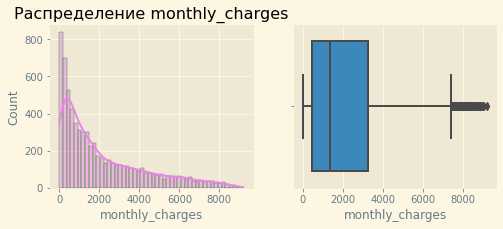

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: monthly_charges, dtype: float64

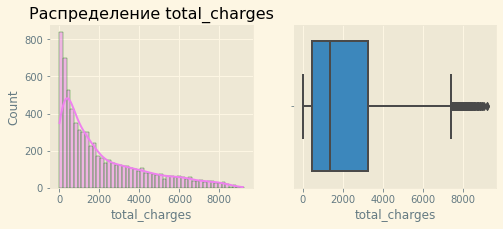

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

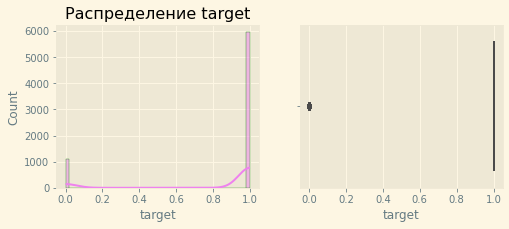

count    7043.000000
mean        0.843675
std         0.363189
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

df_personal
df_internet
df_phone


In [ ]:
plt.style.use('Solarize_Light2')

for df_name in ['df_contract', 'df_personal', 'df_internet', 'df_phone']:
    df = globals()[df_name]
    int_col = select_type_list(df, ['int', 'float'])#, 'datetime']) В тренажёре sns не хочеть работать с форматом даты времени boxplot
    print(f'{df_name}')

    for sign in int_col:
        plt.figure(figsize=(8,  3))

        #Гистограмма
        plt.subplot(1,  2,  1)
        sns.histplot(df[sign], kde=True, color='violet', edgecolor='green', bins=50)
        plt.title(f'Распределение {sign}')

        #Построение ящика
        plt.subplot(1,  2,  2)
        sns.boxplot(df[sign], orient="h")
        plt.setp(plt.gca(),  'yticklabels', [])

        plt.show()
        display(df[sign].describe())

In [ ]:
#Оценка выбросов в общих платежах
df_contract.query('total_charges > 7500').head(8)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
17,9959-WOFKT,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),8257.51,8257.51,1
57,5067-XJQFU,2014-08-01,2020-02-01,One year,Yes,Electronic check,7730.32,7730.32,1
59,5954-BDFSG,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),7740.00,7740.00,1
198,7255-SSFBC,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),8324.46,8324.46,1
369,3520-FJGCV,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),8755.78,8755.78,1
437,4376-KFVRS,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),8211.60,8211.60,1
449,1090-ESELR,2014-02-01,2020-02-01,Two year,No,Bank transfer (automatic),7596.00,7596.00,1
464,1480-BKXGA,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),8355.60,8355.60,1


*Вывод*

Вполне нормальное распределения в датах начала сотрудничества
Дата окончания из-за неизвестности окончания текущих договоров логично стремится к границе времени для данных

Расходы в большинстве своём минимальны, выбросы в общих расходах обусловлены давностью заключенного договора, и тем, что пропуски для данного столбца ранее обнулил

### Оценка категориальных значений
<a id='5-bullet'></a>

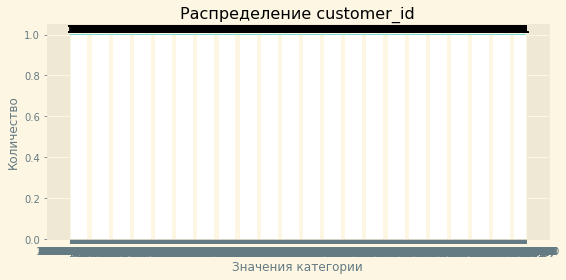

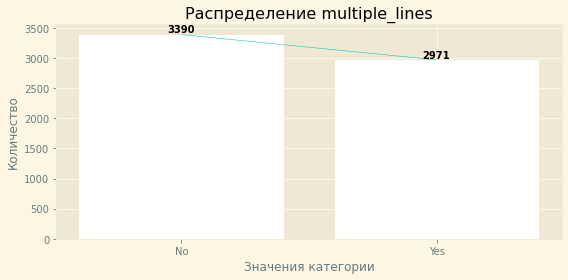

df_contract


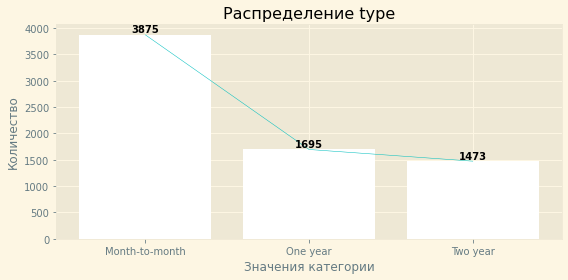

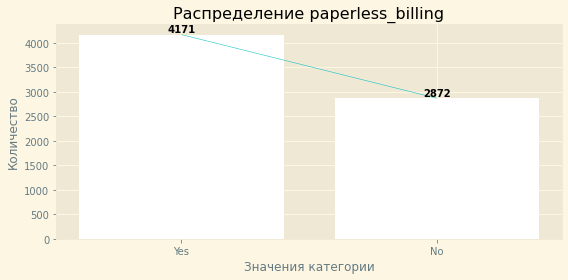

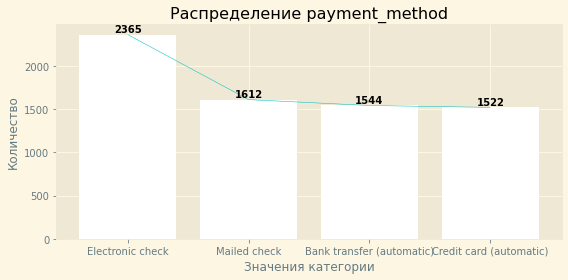

df_personal


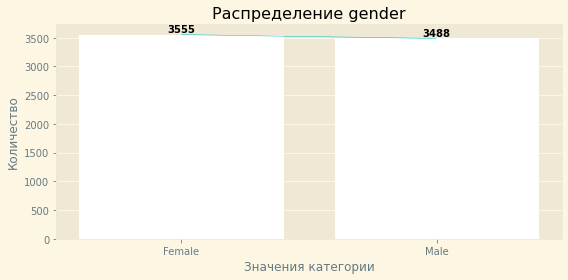

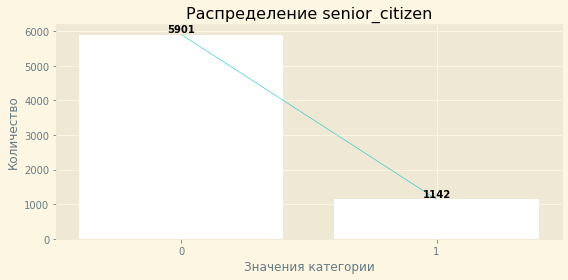

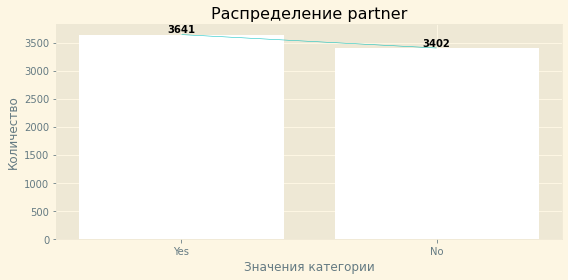

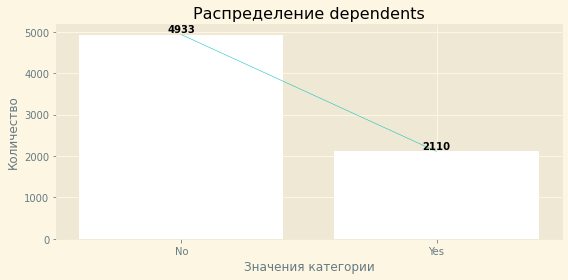

df_internet


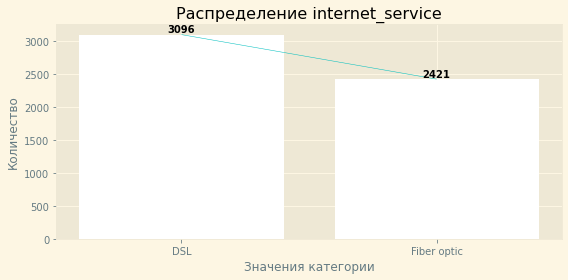

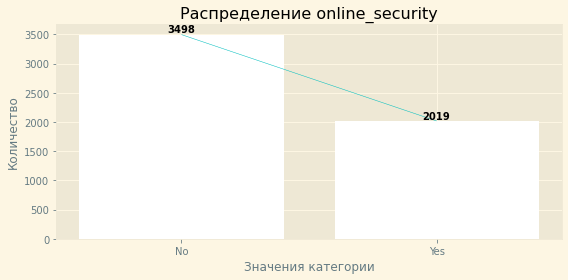

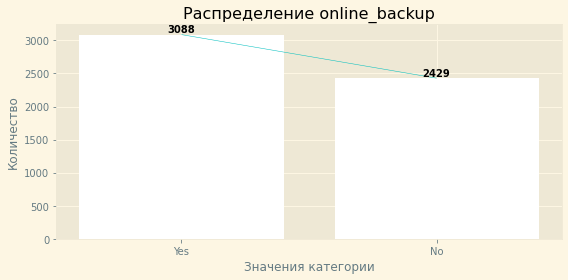

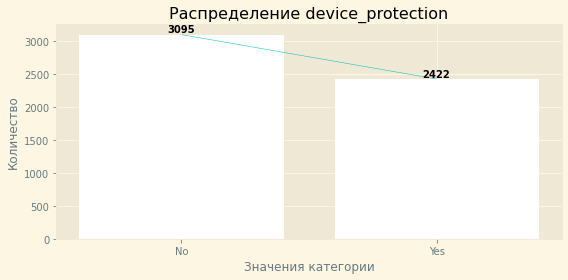

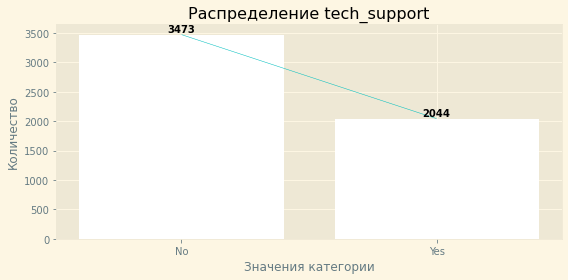

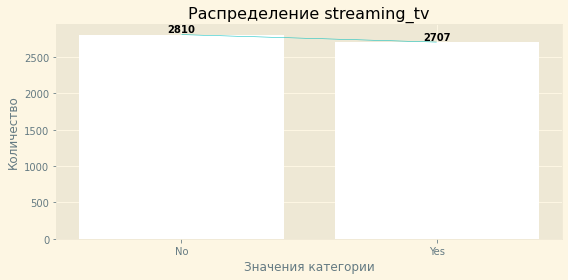

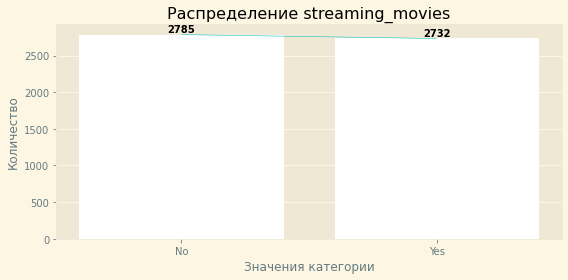

df_phone


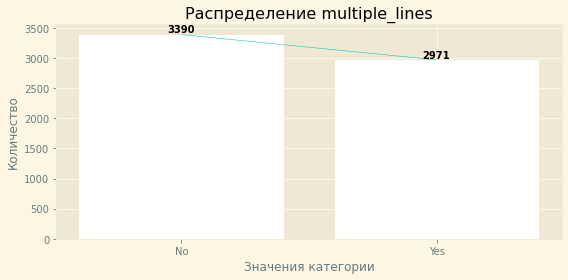

In [ ]:
cat = select_type_list(df, ['object'])

#Функция для визуализации категориальных значений
def visual_cat(df, cat):
    for sign in df.columns:
        if sign in cat:
            unique_values = df[sign].unique()
            value_counts = df[sign].value_counts()

            fig, ax = plt.subplots(figsize=(8, 4))

            bars = ax.bar(unique_values, value_counts.values, color='white')

            ax.plot(range(len(unique_values)), value_counts.values, 'c-', linewidth=0.5)

            ax.set_xlabel('Значения категории')
            ax.set_ylabel('Количество')
            ax.set_title(f'Распределение {sign}')

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height}',
                        ha='center', va='bottom', fontweight='bold')

            plt.tight_layout()
            plt.show()

visual_cat(df, cat)

for df_name in ['df_contract', 'df_personal', 'df_internet', 'df_phone']:
    df = globals()[df_name]
    cat = select_type_list(df, ['object'])
    cat.remove('customer_id')
    print(f'{df_name}')
    visual_cat(df, cat)

*Вывод*

Присутствует небольшой дисбаланс классов у многих признаков, это можно компенсировать параметрами моделей

### Объединение датафреймов
<a id='6-bullet'></a>

In [ ]:
#Слияние в 1 датафрейм
print('Размер до слияния:', len(df_contract))
df = pd.merge(df_contract, df_personal, how='left', on='customer_id')
df = pd.merge(df, df_internet, how='left', on='customer_id')
df = pd.merge(df, df_phone, how='left', on='customer_id')

#Оценка размера  после слияния
print(df.isna().sum())
df.fillna('no_value', inplace=True)
print('Размер датафрейма', len(df))

Размер до слияния: 7043
customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
target                  0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64
Размер датафрейма 7043


*Вывод*

Большое кол-во пропусков в доп.услугах может говорить о том, что клиент их не подключал.

Отсутствие значений в поле `multiple_lines` говорит о том, что у человека нет телефона.

Заменю пропуски значением `no_value`

In [ ]:
#Добавление признака для замены признаков с типом данных datetime
df['total_days'] = (df['end_date'] - df['begin_date']).dt.days

### Построение корреляционной матрицы
<a id='7-bullet'></a>

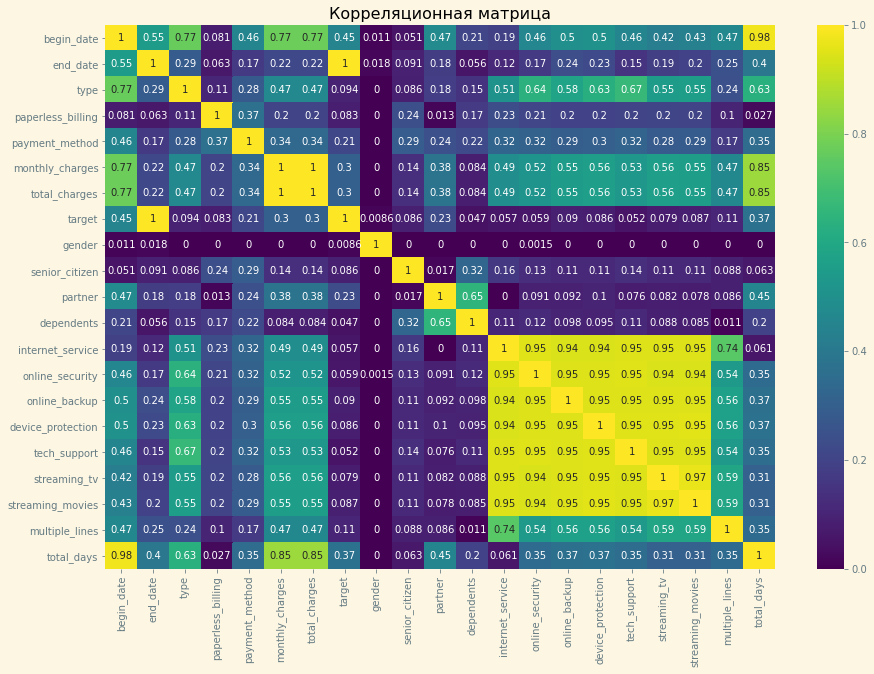

In [ ]:
int_col = select_type_list(df, ['int', 'float'])
date_col = select_type_list(df, ['datetime'])

phik = df[df.columns[~df.columns.isin(['customer_id', date_col])]]

#Построение кор. матрицы
plt.figure(figsize=(15, 10));
sns.heatmap(phik.phik_matrix(interval_cols=int_col),
            annot=True, cmap='viridis');
plt.title('Корреляционная матрица');
plt.show();

*Вывод*

С таргетом крайне мало столбцов имеет зависимость

Блок услуг можно удалить или создать из них 1 признак  

In [ ]:
#Новый признак
list_col_internet = df_internet.columns[2:].to_list()

phik[list_col_internet]= phik[list_col_internet].replace(['Yes', 'No', 'no_value'], [1, 0, 0])
df['service'] = phik[list_col_internet].sum(axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable target for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable end_date for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable target for analysis 1. Dropping this column
  warnings.warn(


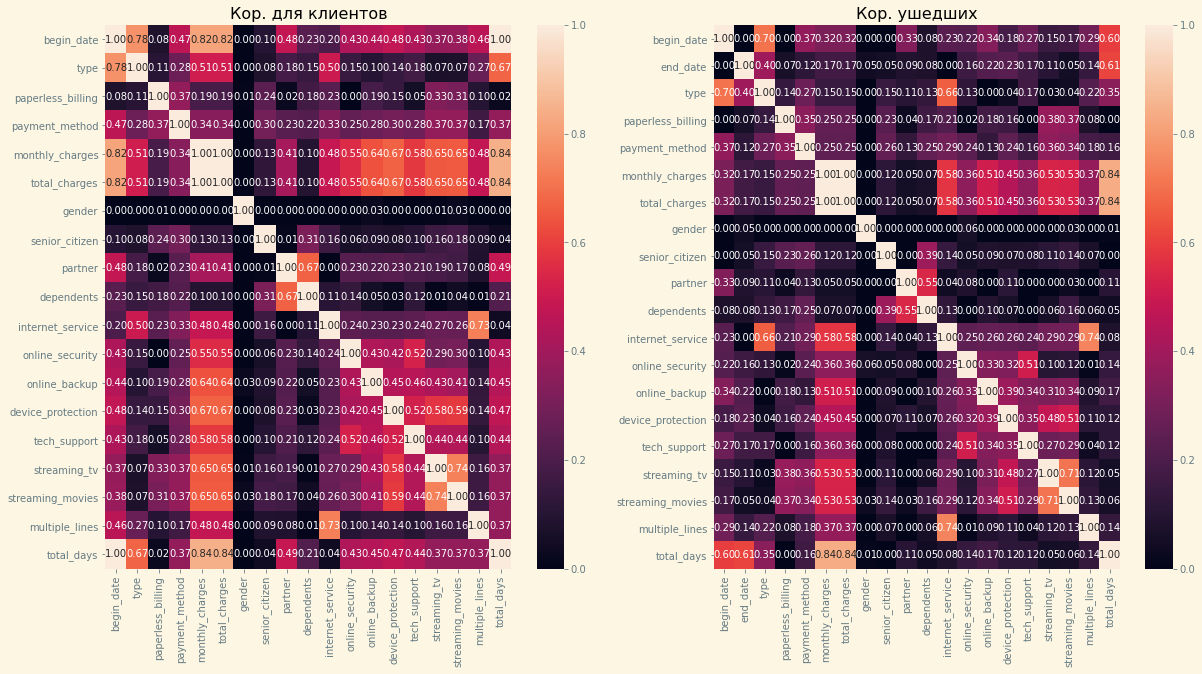

In [ ]:
#Фильтрация
df_good = phik[phik['target'] == 1]
df_bad = phik[phik['target'] == 0]

#Построение
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.heatmap(df_good.phik_matrix(interval_cols=int_col), annot=True, fmt=".2f")
plt.title('Кор. для клиентов')
plt.subplot(1, 2, 2)
sns.heatmap(df_bad.phik_matrix(interval_cols=int_col), annot=True, fmt=".2f")
plt.title('Кор. ушедших')
plt.subplots_adjust(wspace=0.2)
plt.show();

##Подготовка данных к обучению моделей

In [ ]:
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'target',
       'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'total_days',
       'service'],
      dtype='object')

In [ ]:
#Список для удаления лишних признаков
droop = ['multiple_lines', 'internet_service', 'dependents', 'paperless_billing']

In [ ]:
df = df.drop(['begin_date', 'end_date','gender'], axis=1).set_index('customer_id')
#df.drop(list_col_internet, axis=1, inplace=True)
#df.drop(droop, axis=1, inplace=True)

In [ ]:
print('Дубли:',df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

Дубли: 17


### Построение пайплайна предобработки
<a id='8-bullet'></a>

In [ ]:
#Обновление колич. и категориальных признаков
int_col = select_type_list(df, ['int', 'float'])
cat = select_type_list(df, ['object'])

int_col.remove('target')

In [ ]:
TEST_SIZE = 0.25

#Разбивка данных
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1),
    df['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['target'])

#Пайплайны предобрадотки
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', #handle_unknown='ignore',
                              #sparse = False))
                              sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, int_col),
        ('cat', cat_transformer, cat)
    ],
    remainder='passthrough'
)

##Обучение моделей

In [ ]:
def train_model(preprocessor, model_class, param_grid, X_train, y_train, sample_size=None):

    #Пайплайн для предобработки
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_class())
    ])

    #Контроль кол-ва данных для обучения
    if sample_size is not None:
        rng = check_random_state(None)

        unique_indices = np.unique(X_train.index)
        selected_indices = rng.choice(
            unique_indices,
            size=min(sample_size, len(unique_indices)),
            replace=False
        )

        X_sample = X_train.loc[selected_indices]
        y_sample = y_train.loc[selected_indices]
    else:
        X_sample, y_sample = X_train, y_train

    common_indices = set(X_sample.index) & set(y_sample.index)
    common_indices_list = list(common_indices)
    X_sample, y_sample = X_sample.loc[common_indices_list], y_sample.loc[common_indices_list]

    #Случайный подбор параметров
    randomized_search = RandomizedSearchCV(
        pipe,
        param_grid,
        cv=12,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )

    #Обучение
    randomized_search.fit(X_sample, y_sample)
    res = randomized_search.cv_results_
    best_model = randomized_search.best_estimator_.steps[-1][1]
    return res, best_model

### Определение параметров моделей
<a id='9-bullet'></a>

In [ ]:
#Словари
param_grid_catboost = {
    'model__iterations': range(200, 1001, 200),
    'model__learning_rate': [0.1, 0.3, 0.5],
    'model__depth': range(1, 8, 2),
    'model__l2_leaf_reg': [4, 7, 9],
    'model__random_strength': [0.5, 1, 2],
    'model__verbose': [False]
}

param_grid_knn = {
    'model__n_neighbors': range(10, 101, 30),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_randomforest = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [8, 12, 16],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [2, 4, 6],
    'model__class_weight': ['balanced', 'balanced_subsample']
}

### Обучение моделей
<a id='10-bullet'></a>

In [ ]:
models = [
    ('KNN', KNeighborsClassifier),
    ('RandomForest', RandomForestClassifier),
    ('CatBoost', CatBoostClassifier)
]

results = {}
best_models = {}

#Цикл обучения и установка необходимого кол-ва данных
sample_sizes = [None]

for sample_size in sample_sizes:
    for model_name, model_class in models:
            model_results, best_model = train_model(
                preprocessor,
                model_class,
                eval(f'param_grid_{model_name.lower()}'),
                X_train, y_train,
                sample_size=sample_size
            )

            results[f'{model_name}_{sample_size}'] = model_results
            best_models[f'{model_name}_{sample_size}'] = best_model

In [ ]:
#Функция для извлечения из словаря результатов нужных данных
def get_best_hyperparameters_and_roc_auc(results):
    best_params = {}
    best_roc_auc = {}

    for model_name, scores in results.items():
        #Поиск лучших параметров
        best_idx = np.argmax(scores['mean_test_score'])
        best_params[model_name] = scores['params'][best_idx]
        best_roc_auc[model_name] = scores['mean_test_score'][best_idx]

    return best_params, best_roc_auc

best_params, best_roc_auc = get_best_hyperparameters_and_roc_auc(results)

#Результат
print("\nЛучшие гиперпараметры и ROC-AUC для каждой модели:")
for model, params in best_params.items():
    print(f"\n{model}:")
    print(f"ROC-AUC: {best_roc_auc[model]:.4f}")
    print("Гиперпараметры:")
    for key, value in params.items():
        print(f"  {key}: {value}")

print("\nСравнение лучшего ROC-AUC:")
for model, roc_auc in sorted(best_roc_auc.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {roc_auc:.4f}")


Лучшие гиперпараметры и ROC-AUC для каждой модели:

KNN_None:
ROC-AUC: 0.8018
Гиперпараметры:
  model__weights: uniform
  model__n_neighbors: 70
  model__metric: minkowski
  model__algorithm: brute

RandomForest_None:
ROC-AUC: 0.8204
Гиперпараметры:
  model__n_estimators: 300
  model__min_samples_split: 15
  model__min_samples_leaf: 4
  model__max_depth: 16
  model__class_weight: balanced

CatBoost_None:
ROC-AUC: 0.9214
Гиперпараметры:
  model__verbose: False
  model__random_strength: 2
  model__learning_rate: 0.5
  model__l2_leaf_reg: 4
  model__iterations: 200
  model__depth: 3

Сравнение лучшего ROC-AUC:
CatBoost_None: 0.9214
RandomForest_None: 0.8204
KNN_None: 0.8018


### Модель нейронной сети
<a id='11-bullet'></a>

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
#y_train = y_train.astype(int)
#y_test = y_test.astype(int)

In [ ]:
def create_neural_network_model():
    model = Sequential()

    model.add(Dense(512, activation='relu', input_shape=(X_train_transformed.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(1, activation='sigmoid'))

    #Компиляция модели
    optimizer = Nadam(learning_rate=0.001)
    #optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 #metrics=['accuracy', AUC()]
                 metrics=[tf.keras.metrics.AUC(num_thresholds=200)])
    return model

early_stopping = EarlyStopping(
    patience=36,
    min_delta=0.0001,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

neural_network_model = create_neural_network_model()

class PrintEvery10Epochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 15 == 0:
            print(f"\nЭпоха {epoch + 1}")
            print(f"ROC AUC на тренировочном наборе: {logs['auc']:.4f}")
            print(f"ROC AUC на тесте: {logs['val_auc']:.4f}")

history = neural_network_model.fit(
    X_train_transformed,
    y_train,
    batch_size=256,
    epochs=500,
    validation_data=(X_test_transformed, y_test),
    callbacks=[early_stopping, reduce_lr, PrintEvery10Epochs()],
    verbose=0
)

2025-02-22 14:27:10.747066: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Эпоха 1
ROC AUC на тренировочном наборе: 0.5252
ROC AUC на тесте: 0.7252

Эпоха 16
ROC AUC на тренировочном наборе: 0.7223
ROC AUC на тесте: 0.7870

Эпоха 31
ROC AUC на тренировочном наборе: 0.7816
ROC AUC на тесте: 0.8166

Эпоха 46
ROC AUC на тренировочном наборе: 0.8123
ROC AUC на тесте: 0.8193

Эпоха 61
ROC AUC на тренировочном наборе: 0.8055
ROC AUC на тесте: 0.8213


*Вывод*

Архитектура нейронной сети оказалась недостаточно хороша для достижения предсказуемой метрики

##Демонстрация лучшей модели

In [ ]:
y_pred = best_models['CatBoost_None'].predict(X_test_transformed)

print("ROC-AUC на тесте:", roc_auc_score(y_test, best_model.predict_proba(X_test_transformed)[:, 1]).round(4))

ROC-AUC на тесте: 0.9411


In [ ]:
test_class_accuracies = []
test_class_precision = []
test_class_roc_auc = []

test_labels = np.unique(y_test)
for label in test_labels:
    true_labels = y_test == label
    pred_labels = y_pred == label

    pred_probs = best_models['CatBoost_None'].predict_proba(X_test_transformed)[:, 1]

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted',
                                zero_division=0)
    roc_auc = roc_auc_score(true_labels, pred_probs)

    test_class_accuracies.append(accuracy)
    test_class_precision.append(precision)
    test_class_roc_auc.append(roc_auc)


data = {
    'class': test_labels,
    'accuracy': test_class_accuracies,
    'precision': test_class_precision,
    'roc_auc': test_class_roc_auc
}

df_results = pd.DataFrame(data)
display(df_results)

,class,accuracy,precision,roc_auc
0,0,0.941946,0.943102,0.058945
1,1,0.941946,0.943102,0.941055


*Вывод*

Модель достаточно хорошо научилась определять клиентов, которые не планируют уходить

### Матрица ошибок
<a id='12-bullet'></a>

,y_pred,y_true
1,1570,1482
0,187,275


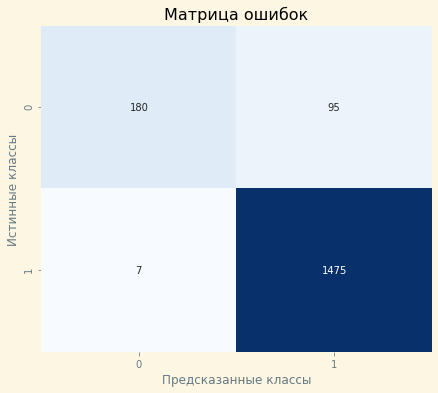

In [ ]:
cm = confusion_matrix(y_test, y_pred)

y_pred_series = pd.Series(y_pred.flatten())

cm_df = pd.concat([y_pred_series.value_counts(), y_test.value_counts()],
                  axis=1, keys=['y_pred', 'y_true'])

display(cm_df)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()

*Вывод*

Треть предсказаний оказалась ложноположительными, что может не совсем хорошо в контексте задачи (Модель ошибочно отметит клиента как "лояльного", из-за чего ему не будет предложены доп. услуги\условия, что в итоге потенциально приведёт к его уходу)  

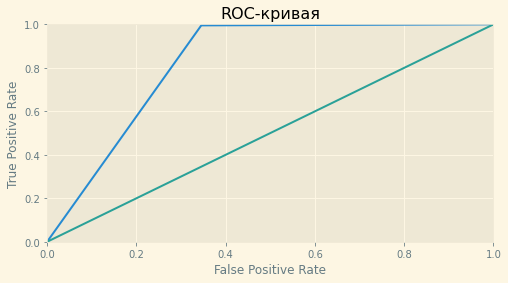

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize = (8,4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

In [ ]:
feature_names = X_test.columns.tolist()

#Функция для извлечения важности признаков
def analyze_feature_importance(model, X_test, y_test):
    feature_importances = best_models['CatBoost_None'].feature_importances_

    #Сортировка
    sorted_features = sorted(zip(feature_importances, feature_names),
                              key=lambda x: abs(x[0]), reverse=True)

    print("Важные признаки для решений модели:")
    for importance, feature in sorted_features:
        print(f"{feature}: {importance:.3f}")

#Результат
analyze_feature_importance(best_model, X_test_transformed, y_test)

Важные признаки для решений модели:
payment_method: 63.679
type: 6.486
paperless_billing: 4.608
senior_citizen: 3.213
monthly_charges: 3.210
device_protection: 2.960
total_charges: 1.868
online_security: 1.770
service: 1.576
tech_support: 0.941
dependents: 0.416
multiple_lines: 0.373
partner: 0.355
online_backup: 0.315
streaming_tv: 0.290
internet_service: 0.261
streaming_movies: 0.000
total_days: 0.000


*Вывод*

Не совсем ожидаемые признаки для принятия решений в топе модели:

- Тип платежа
- Тип оплаты (ежегодно, ежемесячно)
- Расчётный лист

## Итоговый вывод

На основе представленных данных можно сделать следующий общий вывод о проведенных исследованиях:

1. Предобработка и анализ данных

Проведена обработка пропусков, изменение типов данных, переименование столбцов, масштабирование и кодирование признаков. В некоторых случаях были добавлены новые признаки

2. Модели и их обучение

Рассмотрены модели:
- CatBoostClassifier (модель бустинга)
- RandomForestClassifier (случайный лес)
- KNeighborsClassifier (К-ближайших соседей классификатор)
- Нейронная сеть с бинарной классификацией и регуляризацией

Модель CatBoostClassifier со случайным подбором параметров показала себя наиболее эффективной в большинстве случаев

Лучшие результаты по метрике ROC-AUC для этой модели превысили требуемые показатели.

3. Анализ результатов и рекомендации

На тестовых данных модели показали хорошее качество предсказаний, особенно CatBoostClassifier с оптимизированными гиперпараметрами.

Однако были замечены ошибки второго рода, когда модель ошибочно предсказывала, что клиент не откажется от услуг, хотя он планировал разорвать договор. Это имеет значительное значение для бизнеса, так как упущенные клиенты могут привести к финансовым потерям.

Для улучшения качества предсказаний и повышения метрик предлагается:

- Больше изучать и собирать информацию о бывших клиентах, максимизировать обратную связь о причинах ухода
- Собрирать дополнительные данные о клиентах и услугах, например, данные об использовании тарифов.
- Оптимизировать существующие признаки и добавить новые, чтобы улучшить предсказательную способность моделей.
- Рассмотреть применение более сложных архитектур нейронной сети, для дальнейшего улучшения результатов.


4. Рекомендации по внедрению

Рекомендовано использовать CatBoostClassifier для предсказания оттока клиентов.

Внедрение данной модели может помочь снизить уровень оттока и повысить удовлетворенность клиентов, предоставляя возможность компании принимать проактивные меры по удержанию.

Для дальнейшего повышения качества моделей стоит:

- Рассмотреть возможность интеграции новых источников данных, таких как результаты опросов клиентов.

Таким образом, все проведенные исследования достигли поставленных целей, модели показали себя эффективно в задаче предсказания оттока клиентов телекоммуникационных услуг.